<a href="https://colab.research.google.com/github/zseebrz/colab/blob/main/workload_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we update xlrd for reading the Excel files, and plotly and prophet to be able to display charts in plotly

In [1]:
!pip install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 1.3 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.1.0
    Uninstalling xlrd-1.1.0:
      Successfully uninstalled xlrd-1.1.0


In [2]:
!pip install --upgrade plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 5.0 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [3]:
!pip install --upgrade prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
#import plotly.offline as py
#py.init_notebook_mode()

In [5]:
import numpy as np
import pandas as pd

Additional helper functions to create final graph with residuals

In [32]:
from prophet.plot import plot_forecast_component_plotly, get_forecast_component_plotly_props, get_seasonality_plotly_props, make_subplots

try:
    from matplotlib import pyplot as plt
    from matplotlib.dates import (
        MonthLocator,
        num2date,
        AutoDateLocator,
        AutoDateFormatter,
    )
    from matplotlib.ticker import FuncFormatter

    from pandas.plotting import deregister_matplotlib_converters
    deregister_matplotlib_converters()
except ImportError:
    print('Importing matplotlib failed. Plotting will not work.')

try:
    import plotly.graph_objs as go
    from plotly.subplots import make_subplots
except ImportError:
    print('Importing plotly failed. Interactive plots will not work.')

def get_residuals_plotly_props(m, fcst):
    """Prepares a dictionary for plotting the residuals
    Parameters
    ----------
    m: fitted prophet model
    df: the dataframe containing the residuals.
    Returns
    -------
    A dictionary with Plotly traces, xaxis and yaxis
    """

    name = 'residuals'

    prediction_color = '#0072B2'
    error_color = 'rgba(0, 114, 178, 0.2)'  # '#0072B2' with 0.2 opacity
    cap_color = 'black'
    zeroline_color = '#AAA'
    line_width = 2

    range_margin = (fcst['ds'].max() - fcst['ds'].min()) * 0.05
    range_x = [fcst['ds'].min() - range_margin, fcst['ds'].max() + range_margin]

    text = None
    mode = 'lines'

    #full_df['yhat'] - full_df['y']

    traces = []
    traces.append(go.Scatter(
        name=name,
        x=fcst['ds'],
        y=fcst[name],
        mode=mode,
        line=go.scatter.Line(color=prediction_color, width=line_width),
        text=text,
    ))

    xaxis = go.layout.XAxis(
        type='date',
        range=range_x)
    yaxis = go.layout.YAxis(rangemode='normal' if name == 'trend' else 'tozero',
                            title=go.layout.yaxis.Title(text=name),
                            zerolinecolor=zeroline_color)
    if name in m.component_modes['multiplicative']:
        yaxis.update(tickformat='%', hoverformat='.2%')
    return {'traces': traces, 'xaxis': xaxis, 'yaxis': yaxis}

def get_factuals_plotly_props(m, fcst):
    """Prepares a dictionary for plotting the factual data
    Parameters
    ----------
    m: fitted prophet model
    fcst: dataframe containing the forecast(in this case the facts).
    Returns
    -------
    A dictionary with Plotly traces, xaxis and yaxis
    """

    name = 'actual'

    prediction_color = '#0072B2'
    error_color = 'rgba(0, 114, 178, 0.2)'  # '#0072B2' with 0.2 opacity
    cap_color = 'black'
    zeroline_color = '#AAA'
    line_width = 2

    range_margin = (fcst['ds'].max() - fcst['ds'].min()) * 0.05
    range_x = [fcst['ds'].min() - range_margin, fcst['ds'].max() + range_margin]

    text = None
    mode = 'lines'

    #full_df['yhat'] - full_df['y']

    traces = []
    traces.append(go.Scatter(
        name=name,
        x=fcst['ds'],
        #y=fcst[name]
        #we just want to get the actual values from the 'y' column
        y=fcst['y'],
        mode=mode,
        line=go.scatter.Line(color=prediction_color, width=line_width),
        text=text,
    ))

    xaxis = go.layout.XAxis(
        type='date',
        range=range_x)
    yaxis = go.layout.YAxis(rangemode='normal' if name == 'trend' else 'tozero',
                            title=go.layout.yaxis.Title(text=name),
                            zerolinecolor=zeroline_color)
    if name in m.component_modes['multiplicative']:
        yaxis.update(tickformat='%', hoverformat='.2%')
    return {'traces': traces, 'xaxis': xaxis, 'yaxis': yaxis}

def plot_components_plotly_w_residuals(
        m, fcst, uncertainty=True, plot_cap=True, figsize=(900, 200)):
    """Plot the Prophet forecast components using Plotly.
    See plot_plotly() for Plotly setup instructions
    Will plot whichever are available of: trend, holidays, weekly
    seasonality, yearly seasonality, and additive and multiplicative extra
    regressors.
    Parameters
    ----------
    m: Prophet model.
    fcst: pd.DataFrame output of m.predict.
    uncertainty: Optional boolean to plot uncertainty intervals, which will
        only be done if m.uncertainty_samples > 0.
    plot_cap: Optional boolean indicating if the capacity should be shown
        in the figure, if available.
    figsize: Set the size for the subplots (in px).
    Returns
    -------
    A Plotly Figure.
    """

    # Identify components to plot and get their Plotly props
    components = {}
    
    components['actual'] = get_factuals_plotly_props(m, fcst)
    
    components['trend'] = get_forecast_component_plotly_props(
        m, fcst, 'trend', uncertainty, plot_cap)
    if m.train_holiday_names is not None and 'holidays' in fcst:
        components['holidays'] = get_forecast_component_plotly_props(
            m, fcst, 'holidays', uncertainty)

    regressors = {'additive': False, 'multiplicative': False}
    for name, props in m.extra_regressors.items():
        regressors[props['mode']] = True
    for mode in ['additive', 'multiplicative']:
        if regressors[mode] and 'extra_regressors_{}'.format(mode) in fcst:
            components['extra_regressors_{}'.format(mode)] = get_forecast_component_plotly_props(
                m, fcst, 'extra_regressors_{}'.format(mode))
    for seasonality in m.seasonalities:
        components[seasonality] = get_seasonality_plotly_props(m, seasonality)

    components['residuals'] = get_residuals_plotly_props(m, fcst)

    # Create Plotly subplot figure and add the components to it
    fig = make_subplots(rows=len(components), cols=1, print_grid=False)
    fig['layout'].update(go.Layout(
        showlegend=False,
        width=figsize[0],
        height=figsize[1] * len(components)
    ))
    for i, name in enumerate(components):
        if i == 0:
            xaxis = fig['layout']['xaxis']
            yaxis = fig['layout']['yaxis']
        else:
            xaxis = fig['layout']['xaxis{}'.format(i + 1)]
            yaxis = fig['layout']['yaxis{}'.format(i + 1)]
        xaxis.update(components[name]['xaxis'])
        yaxis.update(components[name]['yaxis'])
        for trace in components[name]['traces']:
            fig.append_trace(trace, i + 1, 1)

    


    return fig


We need to download the daily "Accepted vs Delivered" Excel report from the WorkflowDataMonitoring tool, and upload it to Colab

In [7]:
file = '/content/DGT.01-11-2020.01-02-2023.DAY.xls'

df = pd.read_excel(file)

In [8]:
#calculating the total incoming pages for each day
df['workload'] = df['accepted (internal)'] + df['accepted (external)']

In [9]:
#we need to rename the datetime and forecast variable column
df = df.rename(columns={'date': 'ds',
                        'workload': 'y'})

In [10]:
df = df[(df['ds'] < '11-01-2022  11:00:00')]
#let's remove stuff we don't need from the end, so we will have a full month of real data at the end, for better seasonality extraction

In [11]:
#we are adding max and min values to the data, as it is needed for logistic regression later
#the point is that we want to make sure that daily incoming pages cannot go below zero
df['cap'] = 61000
df['floor'] = 0

In [12]:
df.tail(2)

,ds,accepted (internal),accepted (external),production (internal),production (external),expected prod. (int),expected prod. (ext),expected prod. (total),y,cap,floor
711,2022-10-30 11:00:00,0.0,0.0,5.0,0.0,5.00,0.0,5.00,0.0,61000,0
712,2022-10-31 11:00:00,5133.1,1205.9,3970.6,4447.6,4820.86,6441.3,11262.16,6339.0,61000,0


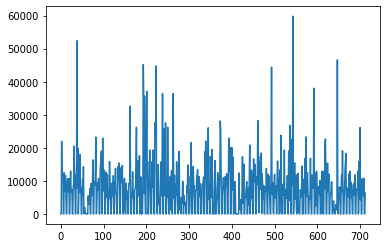

In [13]:
df["y"].plot()

In [14]:
# set the uncertainty interval to 95% (the Prophet default is 80%), add yearly seasonality and use the default linear model
my_model = Prophet(interval_width=0.95, yearly_seasonality=True, daily_seasonality = False)

In [15]:
my_model.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplwdi_5iu/1is_aslm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplwdi_5iu/gs_255he.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62475', 'data', 'file=/tmp/tmplwdi_5iu/1is_aslm.json', 'init=/tmp/tmplwdi_5iu/gs_255he.json', 'output', 'file=/tmp/tmplwdi_5iu/prophet_model39ri3rhu/prophet_model-20221104154814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:48:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:48:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


We are first going to calculate the residuals for the model and plot the components of the historical data, without doing any future forecasting at this point

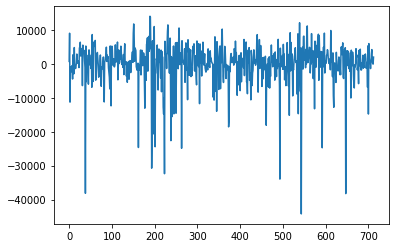

In [16]:
#we predict the historical data using the fitted model and calculate and plot the residuals
forecast_historical = my_model.predict()
full_df = pd.merge(df, forecast_historical, on ='ds')
full_df['residuals'] = full_df['yhat'] - full_df['y']
full_df['residuals'].plot()

In [17]:
#plot the compnents with plotly
fig = plot_components_plotly(my_model, forecast_historical)
fig.show()

In [18]:
#plot the historical forecast with plotly
fig2 = plot_plotly(my_model, forecast_historical)
fig2.show()

Now let's add some future dates and do the forecasting for them. We add 12 business months

In [19]:
future_dates = my_model.make_future_dataframe(periods=12, freq='MS')
future_dates.head()

,ds
0,2020-11-01 11:00:00
1,2020-11-02 11:00:00
2,2020-11-03 11:00:00
3,2020-11-04 11:00:00
4,2020-11-05 11:00:00


In [20]:
future_dates.tail(1)

,ds
724,2023-10-01 11:00:00


In [21]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-11-01 11:00:00,780.725630,-10906.212298,13203.800067
1,2020-11-02 11:00:00,9185.966419,-2611.500674,21293.366946
2,2020-11-03 11:00:00,10680.058524,-749.884942,23102.443577
3,2020-11-04 11:00:00,10597.242754,-1268.285497,23102.581983
4,2020-11-05 11:00:00,9462.099805,-2838.262304,21276.622760


In [22]:
#my_model.plot(forecast, uncertainty=True)
#plot the historical forecast with plotly
fig3 = plot_plotly(my_model, forecast)
fig3.show()

We see that there is something strange, the predicted workload goes into the negative for January 2023. Let's try to use logistic regression with floor and ceiling values!

In [23]:
logistic_model = Prophet(growth='logistic', interval_width=0.95, yearly_seasonality=True, daily_seasonality = False)
#m1 = Prophet()
logistic_model.fit(df)
#we are using the future dates generated before, we just add the floors and ceilings
future_dates['cap'] = 61000
future_dates['floor'] = 0
forecast = logistic_model.predict(future_dates)

DEBUG:cmdstanpy:input tempfile: /tmp/tmplwdi_5iu/jlco_p78.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplwdi_5iu/hxr_jy6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7582', 'data', 'file=/tmp/tmplwdi_5iu/jlco_p78.json', 'init=/tmp/tmplwdi_5iu/hxr_jy6a.json', 'output', 'file=/tmp/tmplwdi_5iu/prophet_modelkt668zwk/prophet_model-20221104154908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [24]:
fig4 = plot_plotly(logistic_model, forecast)
fig4.show()

In [25]:
#plot the compnents of the logistic forecast model with plotly
fig5 = plot_components_plotly(logistic_model, forecast)
fig5.show()

Still looks a bit strange with the negative workload. It is mitigated a bit, but still looks off. Let's try again, by capping the ceiling at 40k and 30k (anything above this is an outlier, and very likely to be included in the forecast tables, so the results should still be sound)

Alias    Description 

B        business day frequency
C        custom business day frequency
D        calendar day frequency
W        weekly frequency
M        month end frequency
SM       semi-month end frequency (15th and end of month)
BM       business month end frequency
CBM      custom business month end frequency
MS       month start frequency
SMS      semi-month start frequency (1st and 15th)
BMS      business month start frequency
CBMS     custom business month start frequency
Q        quarter end frequency
BQ       business quarter end frequency
QS       quarter start frequency
BQS      business quarter start frequency
A, Y     year end frequency
BA, BY   business year end frequency
AS, YS   year start frequency
BAS, BYS business year start frequency
BH       business hour frequency
H        hourly frequency
T, min   minutely frequency
S        secondly frequency
L, ms    milliseconds
U, us    microseconds
N        nanoseconds

In [26]:
logistic_model = Prophet(growth='logistic', 
                         interval_width=0.95, 
                         yearly_seasonality=True,
                         #monthly_seasonality=True,
                         #weekly_seasonality=True,
                         daily_seasonality = False)
#m1 = Prophet()
logistic_model.fit(df)

future_dates = my_model.make_future_dataframe(periods=12, freq='BM')
future_dates['cap'] = 40000
future_dates['floor'] = 0
df['cap'] = 40000
df['floor'] = 0
forecast = logistic_model.predict(future_dates)
fig6 = plot_plotly(logistic_model, forecast)
fig6.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmplwdi_5iu/316prawt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplwdi_5iu/o_v_rl4i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26098', 'data', 'file=/tmp/tmplwdi_5iu/316prawt.json', 'init=/tmp/tmplwdi_5iu/o_v_rl4i.json', 'output', 'file=/tmp/tmplwdi_5iu/prophet_modelihqkqbjj/prophet_model-20221104154922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [27]:
linear_model = Prophet(growth='linear', 
                         interval_width=0.95, 
                         yearly_seasonality=True,
                         weekly_seasonality=True,
                         daily_seasonality = False)
#m1 = Prophet()
linear_model.fit(df)

future_dates = my_model.make_future_dataframe(periods=365, freq='B')
future_dates['cap'] = 30000
future_dates['floor'] = 0
df['cap'] = 30000
df['floor'] = 0
forecast = linear_model.predict(future_dates)
fig7 = plot_plotly(linear_model, forecast)
fig7.show()

DEBUG:cmdstanpy:input tempfile: /tmp/tmplwdi_5iu/k200rtmc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplwdi_5iu/i9ell2sb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74072', 'data', 'file=/tmp/tmplwdi_5iu/k200rtmc.json', 'init=/tmp/tmplwdi_5iu/i9ell2sb.json', 'output', 'file=/tmp/tmplwdi_5iu/prophet_modelf_x9e3oy/prophet_model-20221104154930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:49:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [28]:
fig8 = plot_components_plotly(linear_model, forecast)
fig8.show()

Now, let's use this last model again, but to analyse the original data: calculate the components and the residuals

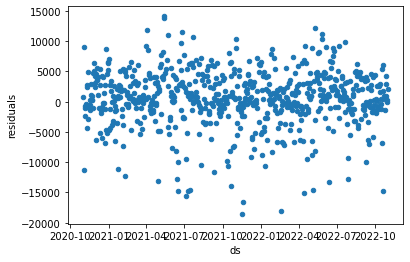

In [29]:
#we predict the historical data using the fitted model and calculate and plot the residuals
forecast_historical = linear_model.predict()
full_df = pd.merge(df[df['y']<30000], forecast_historical, on ='ds')
full_df['residuals'] = full_df['yhat'] - full_df['y']
full_df['month'] = full_df['ds'].dt.month
full_df.plot.scatter(x = 'ds', y = 'residuals')

In [30]:
forecast_residuals = pd.merge(df[df['y']<30000], forecast, on ='ds')
#forecast_residuals = pd.merge(df, forecast, on ='ds')
forecast_residuals['residuals'] = forecast_residuals['yhat'] - forecast_residuals['y']
#forecast_residuals.plot.scatter(x = 'ds', y = 'residuals')

In [33]:
fig9 = plot_components_plotly_w_residuals(linear_model, forecast_residuals)
fig9.show()